# Lab 11: Bootstrap and Hypothesis Testing
Welcome to the eleventh DS102 lab! 

The goal of this lab is to implement bootstrap techniques to perform hypothesis testing in settings where it would have otherwise been very difficult with our previous techniques. We will be implementing the same example that we discussed in [Discussion 10](https://www.data102.org/assets/disc/disc10/disc10_sol.pdf). The discussion and lab are adapted from an example from [Statistics 24600 at UChicago](http://galton.uchicago.edu/~eichler/stat24600/Handouts/bootstrap.pdf).


## Course Policies

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

**Submission**: to submit this assignment, rerun the notebook from scratch (by selecting Kernel > Restart & Run all), and then print as a pdf (File > download as > pdf) and submit it to Gradescope.


**This assignment should be completed and submitted before Thursday April 23, 2020 at 11:59 PM.** 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi, exp, sqrt
%matplotlib inline

# Goal: testing for multimodality
Suppose that $X_1, . . . , X_n$ are an i.i.d. sample from a distribution with continuous density $p(x)$.
One important property of the density $p(x)$ is the number of modes it has. Multimodality of
the density indicates a heterogeneity in the data. In this lab, we will demonstrate how to perform a hypothesis test to determine whether a distribution is multimodal. We'll use the bootstrap to perform this hypothesis test.


# Galaxy data

In this lab we will be working with galaxy data. The dataset contains velocities in km/sec of 82 galaxies from 6 well-separated conic sections of an unfilled survey
of the Corona Borealis region. The distribution
of galaxy velocities provides information about the structure of the far universe—in
particular, a multimodal distribution of velocities is seen as evidence for the existence
of voids and superclusters.

Let $X_1, . . . , X_{n}$ be the velocities of each galaxy, where $X_i$ is the velocity of the $i$th galaxy and we observe $n=82$ galaxies.

We want to test whether or not the distribution that the $X_i$'s are drawn from is multimodal. Let the null and alternative hypotheses be defined as follows:

$$H_0: m(p) = 1$$ 
$$H_A: m(p) > 1$$ 

where $p$ is the distribution of galaxy velocities, and $m$ is the number of modes of a distribution.


## Load the data

First, we'll load the data and see what the histogram looks like.

In [38]:
galaxies_df = pd.read_csv('galaxies.csv', index_col=0, header=0, names=['velocity'])
# Divide all entries by 1000 for ease of reading.
galaxies_df['velocity'] = galaxies_df['velocity'] / 1000
X_observed = galaxies_df['velocity']

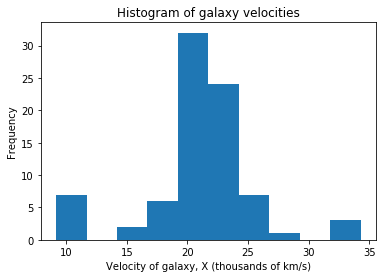

In [39]:
plt.hist(X_observed)
plt.title("Histogram of galaxy velocities")
plt.xlabel("Velocity of galaxy, X (thousands of km/s)")
plt.ylabel("Frequency")
plt.show()

# 1. Estimating the density and test statistic

In order to infer whether or not the $X_1,...,X_{n}$ were drawn from a multimodal distribution, we need to come up with a test statistic that somehow reflects how suitable a unimodal distribution is for
modeling this data. 

To do this, we first need to come up with a model for the density function itself. We’ll model our
data using *kernel density estimation*: 

$$\hat{p}_h(x) = \frac{1}{nh} \sum_{i=1}^n K\left(\frac{x - X_i}{h}\right)$$

$\hat{p}_h(x)$ will be our estimate of the density function. 

As explained in Discussion 10, $K$ is some non-negative kernel function that captures the influence of each data
point $X_i$ on the density of an arbitrary point $x$. A common choice of kernel is the
Gaussian kernel, which is what we will use from now on in this lab: 

$$K(x) = \frac{1}{\sqrt{2\pi}} \exp(-x^2/2)$$

In addition, the parameter $h > 0$ is a bandwidth parameter that captures how close data points $X_i$ must be to $x$ to influence its density: for larger values of $h$, more data points have an
influence on the density at $x$, whereas for smaller values of $h$, only data points very close
to $x$ influence it.

Both $K$ and $h$ are user-selected. In this lab, we will use the above Gaussian kernel for $K(x)$. 

It can be shown that the number of modes of $\hat{p}_h(x)$ (a.k.a. $m(\hat{p}_h(x))$) decreases monotonically as $h$ increases. Therefore, $h$ will be an important tool in our hypothesis test.

## a. Plot the density estimates $\hat{p}_h(x)$

Using the kernel function $K(x) = \frac{1}{\sqrt{2\pi}} \exp(-x^2/2)$, we will first plot $\hat{p}_h(x)$ to get a sense of what these density estimates look like for different values of $h$.

\begin{align*}
\hat{p}_h(x) &= \frac{1}{nh} \sum_{i=1}^n K\left(\frac{x - X_i}{h}\right) \\
&= \frac{1}{nh} \sum_{i=1}^n \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{(x - X_i)^2}{2h^2}\right) \\
&= \frac{1}{nh \sqrt{2\pi}} \sum_{i=1}^n \exp\left(-\frac{(x - X_i)^2}{2h^2}\right) \\
\end{align*}

Using the final simplified form above, implement a function that calculates $\hat{p}_h(x)$ at a given point $x$.

In [97]:
# TODO: Implement the density function \hat{p}_h(x) above.
def phat(x, h, X):
    """Calculates phat_h(x) at a single point x.
    
    Args: 
      x: float, point at which to evaluate the derivative.
      h: float, bandwidth parameter in phat_h.
      X: array of floats of length n containing the observed galaxy velocities.
      
    Returns:
      float, the value of phat_h(x) at the given point x.
    """
    s = 0
    for i in range(1, len(X)+1):
        s += np.exp(-1 * (x - X[i])**2 / 2*h**2)
        
    density = (1 / (len(X)*h*np.sqrt(2*np.pi))) * s # TODO: calculate the density function \hat{p}_h(x).
    return density

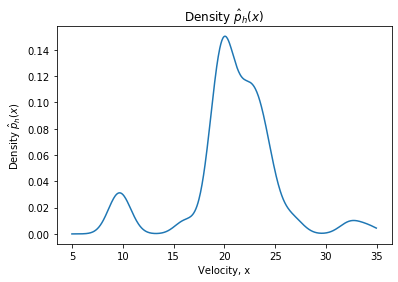

In [109]:
# To test the function above, we now plot \hat{p}_h(x) for different values of h.
# TODO: plug in different values of h below, and observe how the estimated density changes.

h = 1 # TODO: try different values between 1 and 4.

# Grid of xs at which to evaluate the derivative
xs = np.arange(5,35,0.05)
derivs = []
for x in xs:
    derivs.append(phat(x, h, X_observed))

plt.plot(xs, derivs)
plt.title("Density $\hat{p}_h(x)$")
plt.ylabel("Density $\hat{p}_h(x)$")
plt.xlabel("Velocity, x")
plt.show()

### b. Question: For what values of $h$ does the density estimate $\hat{p}_h(x)$ seem to fit the histogram of the data better (higher or lower values of $h$)? Does the density estimate $\hat{p}_h(x)$ seem to contain more modes for higher values of $h$ or lower values of $h$?

h=1 seems to fit the histogram if the data the best. Lower values fit better. The higher h results in much more modes in the data which ends up being too spikey to accurately represent the data.

# 2. Count the modes of $\hat{p}_h(x)$

Now we will write a function that counts the number of modes of a given density estimate $\hat{p}_h(x)$. This is the $m(p)$ function mentioned above. 

To do this, we say that a density function $p$ has a mode everywhere the function $p(x)$ has an increase followed by a decrease. That is, $p(x)$ has an additional mode for each time the derivative of the function $p(x)$ transitions from positive (or 0) to negative.

Following the above definition, to count the number of modes in $\hat{p}_h(x)$, first we will take the derivative, $$\frac{d}{dx}\hat{p}_h(x).$$

Then, we will count the number of times that the derivative transitions from positive (or 0) to negative over a grid of $x$'s.

## a. Calculate the derivative $\frac{d}{dx}\hat{p}_h(x).$

Using the kernel function $K(x) = \frac{1}{\sqrt{2\pi}} \exp(-x^2/2)$, we will now calculate the derivative $\frac{d}{dx}\hat{p}_h(x)$ by applying the chain rule.

\begin{align*}
\frac{d}{dx}\hat{p}_h(x) &= \frac{d}{dx} \frac{1}{nh} \sum_{i=1}^n K\left(\frac{x - X_i}{h}\right) \\
&= \frac{1}{nh} \sum_{i=1}^n \frac{d}{dx} K\left(\frac{x - X_i}{h}\right) \\
&= \frac{1}{nh} \sum_{i=1}^n \frac{1}{h} K'\left(\frac{x - X_i}{h}\right) \\
&= \frac{1}{nh^2} \sum_{i=1}^n \frac{1}{\sqrt{2\pi}} \frac{-(x - X_i)}{h} \exp
\left(-\frac{\left(\frac{x - X_i}{h}\right)^2}{2}\right) \\
&= \frac{1}{nh^3 \sqrt{2\pi}} \sum_{i=1}^n (X_i - x)\exp
\left(-\frac{(x - X_i)^2}{2h^2}\right) \\
\end{align*}

Using the final simplified form of the derivative above, implement a function that calculates $\frac{d}{dx}\hat{p}_h(x)$ at a given point $x$.

In [98]:
# TODO: Implement the derivative of the density function \hat{p}_h(x) above.
def phat_derivative(x, h, X):
    """Calculates the derivative d/dx phat_h(x) at a single point x.
    
    Args: 
      x: float, point at which to evaluate the derivative.
      h: float, bandwidth parameter in phat_h.
      X: array of floats of length n containing the observed galaxy velocities.
      
    Returns:
      float, the derivative d/dx phat_h(x) at the given point x.
    """
    s = 0
    for i in range(1, len(X)):
        s += (X[i] - x) * np.exp(-1 * (x - X[i])**2 / (2*h**2))
    
    
    derivative = (1/ (len(X) * h**3 * np.sqrt(2 * np.pi))) * s # TODO: calculate the derivative of the density function \hat{p}_h(x).
    return derivative

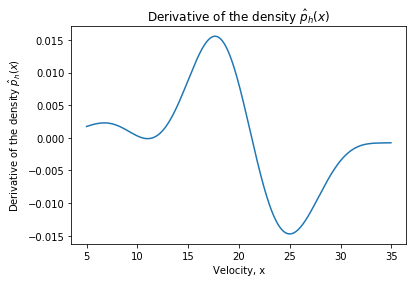

In [99]:
# To test the function above, we now plot the derivative of phat_h(x) for different values of h.
# TODO: plug in different values of h below, and observe how the derivative of the density changes.

h = 3 # TODO: try different values between 1 and 4.

# Grid of xs at which to evaluate the derivative
xs = np.arange(5,35,0.05)
derivs = []
for x in xs:
    derivs.append(phat_derivative(x, h, X_observed))

plt.plot(xs, derivs)
plt.title("Derivative of the density $\hat{p}_h(x)$")
plt.ylabel("Derivative of the density $\hat{p}_h(x)$")
plt.xlabel("Velocity, x")
plt.show()

## b. Count the number of modes in $\hat{p}_h(x)$

Using the derivative calculated above, we will now count the number of modes in $\hat{p}_h(x)$.

To do this, we will evaluate the derivative $\frac{d}{dx}\hat{p}_h(x)$ at a grid of points $x_1,...,x_m$ evenly spaced between $5$ and $35$ (the lower and upper bounds on the velocities in the data), and count the number of times that the derivative crosses from positive to negative.  The use of a grid of $x$'s isn't a perfect measurement of the mode count, since if we don't evaluate the derivative at enough points that are close enough together, we may miss some modes. In this lab we will make sure that the grid we use is fine enough to accurately count the number of modes.

In [100]:
# TODO: Count the modes of phat using the derivative implemented above.
def count_modes(xs, h, X):  
    """Counts the number of modes in phat_h(x), approximated over the given grid of xs.
    
    Counts a mode every time the derivative of phat_h(x) crosses from positive (or 0)
    to negative over the given grid of xs.
    
    Args: 
      xs: array of floats of length m containing points at which to evaluate the derivative.
      h: float, bandwidth parameter in phat_h.
      X: array of floats of length n containing the observed galaxy velocities.
      
    Returns:
      int, the number of modes in phat_h(x).
    """
    # First calculate the derivative at all points in xs.
    derivatives = []
    for x in xs:
        derivatives.append(phat_derivative(x, h, X))
    
    # TODO: Iterate through all of the calculated derivatives, 
    # and add a mode every time the derivative crosses from positive to negative.
    
#     count = 0
#     boo = False
#     for i in range(len(derivatives)-1):
        
#         if boo:
#             if derivatives[i] < 0:
#                 count += 1
#                 boo = False
#         if derivatives[i] > 0:
#             boo = True
#         else:
#             boo = False
        
    
#     num_modes = count # TODO: calculate this by iterating through derivatives.
    
    num_modes = 0
    for i in range(len(derivatives)-1):
        if derivatives[i] >= 0 and derivatives[i+1] < 0:
            num_modes += 1
    return num_modes

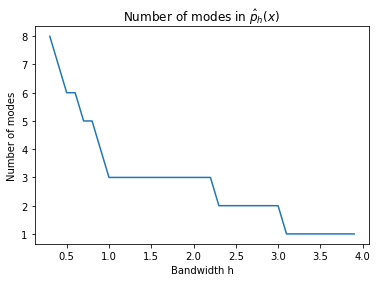

In [101]:
# Plot the number of modes for different values of h.
# No TODOs here, just run this cell to plot.
# This figure should look similar to the figure in Discussion 10.
# This cell may take a few seconds to run.
xs = np.arange(5,35,0.05)
hs = np.arange(0.3,4,0.1)
mode_counts = []
for h in hs:
    mode_counts.append(count_modes(xs, h, X_observed))

plt.plot(hs, mode_counts)
plt.title("Number of modes in $\hat{p}_h(x)$")
plt.ylabel("Number of modes")
plt.xlabel("Bandwidth h")
plt.show()

# 3. Hypothesis test

Now that we've defined the density estimate $\hat{p}_h(x)$ and figured out how to count the number of modes in $\hat{p}_h(x)$, we will move on to testing whether or not a multimodal distribution can reasonably fit our data $X_1,...,X_n$.

In the plot in part 1b), you should have observed that the number of modes in $\hat{p}_h(x)$ decreases monotonically as $h$ increases. Let $H_1$ be the minimal bandwidth value $h$ for which $\hat{p}_h(x)$ is unimodal. 

\begin{align}
    H_1 & = \min \{h \colon m(\hat{p}_h) = 1, \, m(\hat{p}_{h'}) > 1 \text{ for all } h' < h\}.
\end{align}

We will use $H_1$ as the test statistic. 

Notice that $H_1$ depends on the data $X$, because the function $\hat{p}_h(x)$ depends on the data $X$.

##  Computing the $p$-value

For our particular observed dataset $X$, let $h_1$ be the observed minimal bandwidth value $h$ for which $\hat{p}_h(x)$ is unimodal. The $p$-value for our hypothesis test is 

$$P_{0}(H_1 \geq h_1),$$

where $P_0$ is the probability under the null hypothesis that the $X_i$ are drawn from a unimodal distribution. This $p$-value represents the probability under the null hypothesis that we observe a value as extreme as $h_1$.

To perform a hypothesis test at significance level $\alpha$, we reject the null hypothesis if the $p$-value is less than $\alpha$:
$$P_{0}(H_1 \geq h_1) \leq \alpha. $$

Now, we need to calculate the $p$-value. Unfortunately, we don't have a closed form for the distribution of the test statistic $H_1$ under the null hypothesis that the $X_i$ are drawn from a unimodal distribution. In fact, we don't even know what distribution the $X_i$ are drawn from, only that it's unimodal! Still, to estimate the distribution of the test statistic $H_1$, we need to pick some distribution to use for the distribution of the $X_i$'s under the null hypothesis.

Among the parameterized densities $\hat{p}_h(x)$, the density $\hat{p}_{h_1}(x)$ the closest unimodal distribution  to the empirical distribution $p$ of the observed data. So, we will use $\hat{p}_{h_1}(x)$ as the distribution of the $X_i$'s under the null hypothesis.

Therefore, the $p$-value that we will calculate is $$P_{X_i \sim \hat{p}_{h_1}}(H_1 \geq h_1).$$


## a. Calculate $h_1$
To calculate the $p$-value, the first thing we need to do is calculate $h_1$. To do this, we will try different values of $h$ until we find the smallest value such that the density estimate $\hat{p}_h$ has $2$ modes.

In [102]:
# No TODOs here, just understand what this function is doing.
def find_h1(xs, X, h_min=0.3, h_max=4, h_err = 0.01, k=1):
    """Calculates h1, the minimum bandwidth h such that the density estimate phat_h has k modes.
    
    Chooses h1 from within an interval bounded by h_min and h_max, within error h_err.
    
    Args:
      xs: array of floats containing points xs to use to count the number of modes in phat_h.
      X: array of floats of length n containing the observed galaxy velocities.
      h_min: float, minimum h to try.
      h_max: float, maximum h to try.
      h_err: float, allowed error of h, or step size of hs to try between h_min and h_max.
      k: number of modes being tested in the hypothesis test.
      
    Returns:
      h1: minimum bandwith h among candidate hs such that phat_h has k modes.
    """
    # Perform a binary search to find the minimum bandwith h1.
    h_opt = 0
    h_min = hs[0]
    h_max = hs[-1]
    modes_min = count_modes(xs, h_min, X)
    modes_max = count_modes(xs, h_max, X)
    while h_max - h_min > h_err:
        h_opt = (h_min + h_max) / 2
        modes_opt = count_modes(xs, h_opt, X)
        if modes_opt > k:
            h_min = h_opt
            modes_min = modes_opt
        else:
            h_max = h_opt
            modes_max = modes_opt
    return h_max

To calculate the value $h_1$ for the null hypothesis, we apply this function over the observed data $X_1,...,X_n$.

In [103]:
# No TODOs here, just run this cell to calculate the value of h1 using the function above.
# If everything is correct you should expect this value to be close to 3.05.
xs = np.arange(5,35,0.05)
h1 = find_h1(xs, X_observed, k=1)
print("Estimate value of h_1:", h1)

Estimate value of h_1: 3.0492187500000005


##  b. Sampling from $\hat{p}_{h_1}$ using the bootstrap

To calculate the $p$-value, we will first draw i.i.d. samples from $\hat{p}_{h_1}$, and then observe the number of times that the $H_1$ calculated from those samples is greater than or equal to $h_1$. We will use the bootstrap to draw the i.i.d. samples from $\hat{p}_{h_1}$.

Let $Z^{*} = (Z_1^*, \ldots, Z_{82}^*)$ denote a bootstrap sample from the dataset. It can be shown that 
$Z_i^* + h_1 \epsilon_i$ for $\epsilon_i \sim \mathcal{N}(0, 1)$ gives i.i.d. samples from $\hat{p}_{h_1}$.

This leads to the following bootstrap algorithm: 

1. Draw $B$ independent bootstrap samples $X^{*(1)}, \ldots, X^{*(B)}$ from the null distribution $\hat{p}_{h_1}$, where in spirit,
    \begin{align}
        X_i^{*(b)} & = Z_i^{*(b)} + h_1 \epsilon_i^{(b)} \\
        \epsilon_i^{(b)} & \sim \mathcal{N}(0, 1)
    \end{align}
    
    Since the variance of the bootstrap sample has been increased by adding the normal error term, the data are usually rescaled to have the same sample variance as the original observations. So, it will actually work better if we replace the equation above in the algorithm with 
    
    \begin{align}
        X_i^{*(b)} & = \bar{Z}^{*(b)} + (1 + h_1^2/\hat{\sigma}^2)^{-1/2} (Z_i^{*(b)} - \bar{Z}^{*(b)} + h_1\epsilon_i^{(b)}).
    \end{align}
    
    where $\bar{Z}^{*(b)}$ is the sample mean of the bootstrap samples $Z^{*(b)}$.
    
    We'll use this second, more complicated variance scaling in the code.
    
2. Evaluate the $B$ bootstrap replicates of the test statistic $H_1^{*(b)}$ for $b = 1, \ldots, B$.
3. Estimate the $p$-value using these bootstrap replicates (which provide an estimate of the distribution of the test statistic under the null hypothesis):
    \begin{align}
        \text{estimate of }  \mathbb{P}_0(H_1 \geq h_1) = \frac{1}{B} \sum_{b = 1}^B 1[H_1^{*(b)} \geq h_1].
    \end{align}

In [114]:
# TODO: estimate the p-value using bootstrap samples from the observed data.
def estimate_p_value(X, B, k=1):
    """Estimates the p-value for the hypothesis test.
    
    Args: 
      X: array of floats of length n containing the observed galaxy velocities.
      B: number of bootstrap samples to draw.
      n: number of samples to draw per bootstrap sample.
      k: number of modes we are testing for.
    
    Returns:
      float, an estimate of the p-value.
    """
    # Find h1 for the distribution under the null hypothesis.
    xs = np.arange(5,35,0.05)
    h1 = find_h1(xs, X, k=k)
    # Count of the number of times H1 >= h1.
    H1_greater_count = 0
    # Variance of the observed data X for rescaling the data.
    X_var = np.var(X)
    n = len(X)
    for _ in range(B):
        # TODO: obtain the bootstrap sample Z*. 
        # Z_star should be an array of n samples drawn from the data array X, sampled with replacement.
        # Hint: use np.random.choice.
        Z_star = np.random.choice(X, n, replace=True) # TODO: obtain the bootstrap sample Z*. 
        
        Z_bar = np.mean(Z_star)
        epsilon = np.random.normal(size=n)
        X_star = Z_bar + (1 / sqrt(1 + ((h1**2) / X_var))) * (Z_star - Z_bar + (h1 * epsilon))
        
        # Check if H1 >= h1. Instead of explicitly calculating H1 (which could take long), 
        # we are using a shortcut where we count the number of modes in X_star under bandwidth value h1.
        # If the counted number of modes is greater than the number of modes used to find h1 
        # for the observed data, then the bandwidth value H1 is greater than or equal to the bandwidth value h1.
        # This is true because of number of modes is monotonically decreasing in the bandwidth value h.
        modes = count_modes(xs, h1, X_star)
        if modes > k:
            H1_greater_count += 1
             
    return H1_greater_count / B

In [115]:
# No TODOs here, run this cell to calculate the p-value.
p_val_1 = estimate_p_value(X_observed, 100, k=1)
print("p-value for test for more than 1 mode:", p_val_1)

p-value for test for more than 1 mode: 0.0


## c. Try testing for different numbers of modes.

Up to this point, we've been focusing on testing whether the distribution has more than 1 mode. With our estimate of p-value above, we should have observed that the p-value for the null hypothesis that the distribution has 1 mode is very small (close to 0). 

If we reject the hypothesis that the distribution of the data has 1 mode, what about testing if the distribution has more than $k$ modes? Turns out we can apply the same techniques to test 

$$H_0: m(p) = k$$ 
$$H_A: m(p) > k$$ 

Below, we apply the same techniques to estimate the $p$-values for $k = 2$ and $k = 3$.

In [116]:
# No TODOs here, run this cell to calculate the p-value.
# k = 2
p_val_2 = estimate_p_value(X_observed, 100, k=2)
print("p-value for test for more than 2 modes:", p_val_2)

p-value for test for more than 2 modes: 0.05


In [ ]:
# No TODOs here, run this cell to calculate the p-value.
# k = 3
p_val_3 = estimate_p_value(X_observed, 100, k=3)
print("p-value for test for more than 3 modes:", p_val_3)

### Question: for which values of $k$ were you able to reject the null hypothesis? Did this match your expectation of the number of modes in the data based on looking at the initial histogram?

We were able to reject the null hypothesis with k=3 with p-value of 0.44. This follows my expectation because there are three visible peaks.